## Finetune QWEN2.5-VL-7B

In [1]:
!nvidia-smi

Sat Sep 13 21:57:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN Xp                On  |   00000000:02:00.0 Off |                  N/A |
| 23%   27C    P8              9W /  250W |       2MiB /  12288MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # Automatically loads .env from the current directory

hf_token = os.getenv("HF_TOKEN")
roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

# Optional: Set them in os.environ if downstream libraries expect them there
os.environ["HF_TOKEN"] = hf_token
os.environ["ROBOFLOW_API_KEY"] = roboflow_api_key

### Data Prep

### Train data

In [ ]:
import pandas as pd
import os
import json
img_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_lower_20250512/labels_train.txt"
# all image names in image_path
image_folder = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_lower_20250512/images"
# get the list of all image names in the directory
img_list = os.listdir(image_folder)
print(f"Number of images in {image_folder}: {len(img_list)}")

img_csv = pd.read_csv(img_path, sep=",")
img_dict_train= {}
for index, row in img_csv.iterrows():
    if row['image_path'] in img_list:
        img_dict_train[row['image_path']] = (row['label'], 1) # dummy freq, we don't really need it for val and validation

with open("/swdata/yin/Cui/EM/reveil/data/zh/zh-char/lower/img_dict_train.json", "w", encoding="utf-8") as f:
    for key, value in img_dict_train.items():
        f.write(json.dumps({'image': key, 'prefix': '请识别图片中的汉字', 'label': value[0], 'normal_freq': value[1]}, ensure_ascii=False) + "\n")

# print the img_dict
# print the first 10 items
for i, (key, value) in enumerate(img_dict_train.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

zh_chars_train = list(img_dict_train.keys())
len(zh_chars_train)

### Test Data

In [ ]:
import pandas as pd
import os
import json
# for test dataset, the img items are also stored in annotation file
annotation_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/char_freqs.csv"
image_folder = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/upper/images"
# get the list of all image names in the directory
img_list = os.listdir(image_folder)
print(f"Number of images in {image_folder}: {len(img_list)}")

annotation_csv = pd.read_csv(annotation_path, sep=",")
img_dict_test= {}
for index, row in annotation_csv.iterrows():
    if row['image_path'] in img_list:
        # img_dict_test[row['image_path']] = (row['label'], row['normal_freq'])
        img_dict_test[row['image_path']] = (row['label'], row['normal_freq']) # we only need the freq for test set, in baseline model.

with open("/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/upper/img_dict_test.json", "w") as f:
    # dump to jsonl format
    for key, value in img_dict_test.items():
        f.write(json.dumps({'image': key, 'prefix': '请识别图片中的汉字', 'label': value[0], 'normal_freq': value[1]}, ensure_ascii=False) + "\n")

for i, (key, value) in enumerate(img_dict_test.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

zh_chars_test = list(img_dict_test.keys())
len(zh_chars_test)

### Vali Data

In [ ]:
img_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_lower_20250512/labels_val.txt"
image_folder = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_lower_20250512/images"
# get the list of all image names in the directory
img_list = os.listdir(image_folder)
print(f"Number of images in {image_folder}: {len(img_list)}")

img_csv = pd.read_csv(img_path, sep=",")
img_dict_val= {}
for index, row in img_csv.iterrows():
    if row['image_path'] in img_list:
        img_dict_val[row['image_path']] = (row['label'], 1) # dummy freq, we don't really need it for val and validation

with open("/swdata/yin/Cui/EM/reveil/data/zh/zh-char/lower/img_dict_val.json", "w", encoding="utf-8") as f:
    for key, value in img_dict_val.items():
        f.write(json.dumps({'image': key, 'prefix': '请识别图片中的汉字', 'label': value[0], 'normal_freq': value[1]}, ensure_ascii=False) + "\n")

# print the img_dict
# print the first 10 items
for i, (key, value) in enumerate(img_dict_val.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

zh_chars_val = list(img_dict_val.keys())
len(zh_chars_val)

### Format data for model

In [4]:
# SYSTEM_MESSAGE = "You are a helpful assistant that can identify Chinese characters in images. The image will show only the upper half of a character, with the lower half masked. Identify the character accurately based on the visible portion.  Please answer with a single character, and do not include any other text."
# PROMPT = "The image contains the upper half of a Chinese character. The lower half is masked. What is the character in the image? Please answer with a single word, and do not include any other text. The character is:"

# image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_whole_20250512"
# image_directory_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/whole/images"
# SYSTEM_MESSAGE = "你是一个善于识别汉字的智能助手。图片展示了一个汉字，请你准确识别该汉字，你的回答只能包含一个汉字。"
# PROMPT = "这张图片上有一个汉字。请判断这是什么汉字，只回答一个汉字，不要包含其他内容。这个汉字是：" 

# image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_upper_20250512/images"
# image_directory_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/upper/images"
# SYSTEM_MESSAGE = "你是一个善于识别汉字的智能助手。图片只展示了一个汉字的上半部分，请你根据上半部分准确识别该汉字，只回答一个汉字。"
# PROMPT = "这张图片显示的是一个汉字的上半部分，下半部分被遮挡住了。请根据可见部分判断这是什么汉字，只回答一个汉字，不要包含其他内容。这个汉字是："

# image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_top3500_rep5_multiFonts202512/zh_char_lower_20250512/images"
image_directory_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/lower/images"
SYSTEM_MESSAGE = "你是一个善于识别汉字的智能助手。图片只展示了一个汉字的下半部分，请你根据下半部分准确识别该汉字，只回答一个汉字。"
PROMPT = "这张图片显示的是一个汉字的下半部分，上半部分被遮挡住了。请根据可见部分判断这是什么汉字，只回答一个汉字，不要包含其他内容。这个汉字是："

def format_data(image_directory_path, entry):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": SYSTEM_MESSAGE}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_directory_path + "/" + entry['image'],
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": entry['label']}],
        },
    ]


In [5]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset

class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        # print(entries )
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry, format_data(self.image_directory_path, entry)

In [6]:

# train_dataset = JSONLDataset(
#     jsonl_file_path="/swdata/yin/Cui/EM/reveil/data/zh/zh-char/upper/img_dict_train.json",
#     image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_upper_20250512/images",
# )

# valid_dataset = JSONLDataset(
#     jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/upper/img_dict_val.json",
#     image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_upper_20250512/images",
# )

# test_dataset = JSONLDataset(
#     jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/whole/img_dict_test.json",
#     image_directory_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/whole/images",
# )

# test_dataset = JSONLDataset(
#     jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/upper/img_dict_test.json",
#     image_directory_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/upper/images",
# )

test_dataset = JSONLDataset(
    jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/lower/img_dict_test.json",
    image_directory_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/lower/images",
)

In [ ]:
# test_dataset = [test_dataset2[i] for i in range(20)]

In [9]:
# train_dataset[0]

test_dataset[3]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=54x50>,
 {'image': '3.jpg', 'prefix': '请识别图片中的汉字', 'label': '上', 'normal_freq': 1},
 [{'role': 'system',
   'content': [{'type': 'text',
     'text': '你是一个善于识别汉字的智能助手。图片只展示了一个汉字的下半部分，请你根据下半部分准确识别该汉字，只回答一个汉字。'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': '/swdata/yin/Cui/EM/reveil/data/zh/zh-char/onestop/zh_char_onestop_uniqueChar_newFont/lower/images/3.jpg'},
    {'type': 'text',
     'text': '这张图片显示的是一个汉字的下半部分，上半部分被遮挡住了。请根据可见部分判断这是什么汉字，只回答一个汉字，不要包含其他内容。这个汉字是：'}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': '上'}]}])

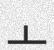

In [10]:
test_dataset[3][0]

## Zero-Shot Qwen2.5-VL-7b

In [ ]:
from maestro.trainer.models.qwen_2_5_vl.checkpoints import load_model, OptimizationStrategy

MODEL_ID_OR_PATH = "Qwen/Qwen2.5-VL-7B-Instruct"
# MODEL_ID_OR_PATH = "Qwen/Qwen2.5-VL-72B-Instruct"
MIN_PIXELS = 28 * 28
MAX_PIXELS = 1028 * 28 * 28

In [ ]:
processor, model = load_model(
    model_id_or_path=MODEL_ID_OR_PATH,
    optimization_strategy=OptimizationStrategy.NONE,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)

In [ ]:
import torch
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor

from maestro.trainer.common.utils.device import parse_device_spec
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation

def predict_score_with_inputs(
    model: Qwen2_5_VLForConditionalGeneration,
    processor: Qwen2_5_VLProcessor,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    pixel_values: torch.Tensor,
    image_grid_thw: torch.Tensor,
    device: torch.device,
    max_new_tokens: int = 1024,
) -> list[str]:
    """
    Generates predictions from the Qwen2.5-VL model using both textual and visual inputs.

    Args:
        model (Qwen2_5_VLForConditionalGeneration):
            A Qwen2.5-VL model capable of conditional text generation with visual context.
        processor (Qwen2_5_VLProcessor):
            Preprocessing and postprocessing utility for the Qwen2.5-VL model.
        input_ids (torch.Tensor):
            Tokenized input text IDs.
        attention_mask (torch.Tensor):
            Attention mask corresponding to the tokenized input.
        pixel_values (torch.Tensor):
            Preprocessed image data (pixel values) for visual inputs.
        image_grid_thw (torch.Tensor):
            Tensor specifying the layout or shape of the provided images.
        device (torch.device):
            Device on which to run inference (e.g., ``torch.device("cuda")`` or ``torch.device("cpu")``).
        max_new_tokens (int):
            Maximum number of tokens to generate.

    Returns:
        list[str]: A list of decoded strings corresponding to the generated sequences.
    """
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            pixel_values=pixel_values.to(device),
            image_grid_thw=image_grid_thw.to(device),
            max_new_tokens=max_new_tokens,
            output_scores=True,
            return_dict_in_generate=True,
            do_sample=False,  # Non-greedy decoding
        )
        generated_ids = [
            generated_sequence[len(input_sequence) :]
            for input_sequence, generated_sequence in zip(input_ids, outputs.sequences)
        ]
        return processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False), outputs.scores

In [ ]:
from PIL import Image
from typing import Optional, Tuple, Union
import numpy as np
import json

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info
import torch
import torch.nn.functional as F

def run_qwen_2_5_vl_inference(
    model,
    processor,
    conversation: Union[str, dict],
    target_token: str = "a",
    device: str = "auto",
    max_new_tokens: int = 1024,
) -> Tuple[str, Tuple[int, int]]:
    device = parse_device_spec(device)
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=text,
        images=image_inputs,
        return_tensors="pt",
    )
    responses, scores = predict_score_with_inputs(
        **inputs,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=max_new_tokens
    )
    response = responses[0]

    logits = scores[0][0]
    probs = F.softmax(logits, dim=-1)
    target_token_tokenized = processor.tokenizer.tokenize(target_token) 
    target_token_id = processor.tokenizer.convert_tokens_to_ids(target_token_tokenized[0])  # a few target tokens will have multiple subtokens
    prob_target = probs[target_token_id].item()

    # Entropy of the distribution
    entropy = -(probs * probs.log()).sum().item()

    # Top-5 predictions with probabilities and logits
    topk_probs, topk_ids = torch.topk(probs, k=5)
    topk_tokens = [processor.tokenizer.decode([idx]).strip() for idx in topk_ids]
    top5 = [
        {"token": tok, "prob": prob.item(), "logit": logits[idx].item()}
        for tok, prob, idx in zip(topk_tokens, topk_probs, topk_ids)
    ]

    return {
        "response": response,
        "target": target_token,
        "prob_target": prob_target,
        "entropy": entropy,
        "top5": top5
    }



In [ ]:
import csv
ent = 0.0
acc = 0.0
cross_ent = 0.0
results = []
csv_rows = []
json_path = "/swdata/yin/Cui/EM/reveil/precomputed/ZH/char/onestop/whole/zero_shot_zh_char_whole.json"
csv_path = "/swdata/yin/Cui/EM/reveil/precomputed/ZH/char/onestop/whole/zero_shot_zh_char_whole.csv"

for image, entry, conversations in test_dataset:
    image_id = entry['image']
    conversation = conversations[:2]
    target = entry['label']
    freq = entry['normal_freq']

    result = run_qwen_2_5_vl_inference(model=model, processor=processor, conversation = conversation, target_token=target, device="cuda", max_new_tokens=10)
    response = result['response']
    prob_target = result['prob_target']
    entropy = result['entropy']
    surp = -np.log(prob_target)
    accuracy = int(response.strip() == target.strip())

    print(f"Target_Char: {target}, Response: {result['response']}")

    # ent +=  entropy * freq
    ent += entropy
    # cross entropy is the negative log likelihood of the target token
    cross_ent += surp
    print(f"Entropy: {result['entropy']:.4f}, Cumulative Entropy: {ent:.4f}, Surprisal: {surp:.4f}")
    
    # check accuracy
    acc += accuracy

    results.append(result)

    csv_rows.append([
        image_id, target, freq, entropy, surp, prob_target, response, accuracy
    ])

with open(json_path, "w") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "image_id", "target", "freq", "entropy", "surprisal", "prob_target", "response", "acc"
    ])
    writer.writerows(csv_rows)

# print(f"Entropy: {ent:.4f}")
print(f"Entropy: {ent / len(test_dataset):.4f}")
print(f"Cross Entropy: {cross_ent / len(test_dataset):.4f}")
print(f"Recognition Accuracy: {acc / len(test_dataset):.4f}")

### Unconditional Entropy

In [ ]:
def entropy(freqs):
    total = sum(freqs)
    if total == 0:
        return 0
    return -sum((f / total) * np.log(f / total) for f in freqs if f > 0)
# print("Entropy of letters:", entropy([english_letter_freq[letter] for letter in english_letter_freq.keys()]))
print("Unconditional Entropy of Chinese Characters:", entropy([test_item[1]['normal_freq'] for test_item in test_dataset]))

In [ ]:
## re-calculate the entropy by just take their mean since it is conditioned on image input which can be treated as unique.
import numpy as np
import csv
import pandas as pd

# Define the file path
file_path = '/swdata/yin/Cui/EM/reveil/precomputed/ZH/char/onestop/whole/zero_shot_zh_char_whole.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Compute the mean of the "entropy" column
mean_entropy = df['entropy'].mean()
item = len(df)
mi = 7.11589- mean_entropy

print(f"Mean entropy: {mean_entropy}")

print(mi)

print(item)


# Use Finetuned Model

# Model Load

In [11]:
import torch

from peft import get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor

MIN_PIXELS = 28 * 28
MAX_PIXELS = 1280 * 28 * 28

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "/swdata/yin/Cui/EM/reveil/models/qwen2.5-7b-instruct-reveil-zh-char-lower/best",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16
)

processor = Qwen2_5_VLProcessor.from_pretrained(
    "/swdata/yin/Cui/EM/reveil/models/qwen2.5-7b-instruct-reveil-zh-char-lower/best",
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)



/swdata/yin/miniconda3/envs/reveil/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
import torch
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor

from maestro.trainer.common.utils.device import parse_device_spec
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation

def predict_score_with_inputs(
    model: Qwen2_5_VLForConditionalGeneration,
    processor: Qwen2_5_VLProcessor,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    pixel_values: torch.Tensor,
    image_grid_thw: torch.Tensor,
    device: torch.device,
    max_new_tokens: int = 1024,
) -> list[str]:
    """
    Generates predictions from the Qwen2.5-VL model using both textual and visual inputs.

    Args:
        model (Qwen2_5_VLForConditionalGeneration):
            A Qwen2.5-VL model capable of conditional text generation with visual context.
        processor (Qwen2_5_VLProcessor):
            Preprocessing and postprocessing utility for the Qwen2.5-VL model.
        input_ids (torch.Tensor):
            Tokenized input text IDs.
        attention_mask (torch.Tensor):
            Attention mask corresponding to the tokenized input.
        pixel_values (torch.Tensor):
            Preprocessed image data (pixel values) for visual inputs.
        image_grid_thw (torch.Tensor):
            Tensor specifying the layout or shape of the provided images.
        device (torch.device):
            Device on which to run inference (e.g., ``torch.device("cuda")`` or ``torch.device("cpu")``).
        max_new_tokens (int):
            Maximum number of tokens to generate.

    Returns:
        list[str]: A list of decoded strings corresponding to the generated sequences.
    """
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            pixel_values=pixel_values.to(device),
            image_grid_thw=image_grid_thw.to(device),
            max_new_tokens=max_new_tokens,
            output_scores=True,
            return_dict_in_generate=True,
            do_sample=False,  # Non-greedy decoding
        )
        generated_ids = [
            generated_sequence[len(input_sequence) :]
            for input_sequence, generated_sequence in zip(input_ids, outputs.sequences)
        ]
        return processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False), outputs.scores

In [13]:
from PIL import Image
from typing import Optional, Tuple, Union
import numpy as np
import json

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info
import torch
import torch.nn.functional as F

def run_qwen_2_5_vl_inference(
    model,
    processor,
    conversation: Union[str, dict],
    target_token: str = "a",
    device: str = "auto",
    max_new_tokens: int = 1024,
) -> Tuple[str, Tuple[int, int]]:
    device = parse_device_spec(device)
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=text,
        images=image_inputs,
        return_tensors="pt",
    )
    responses, scores = predict_score_with_inputs(
        **inputs,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=max_new_tokens
    )
    response = responses[0]

    logits = scores[0][0]
    probs = F.softmax(logits, dim=-1)
    target_token_tokenized = processor.tokenizer.tokenize(target_token) 
    target_token_id = processor.tokenizer.convert_tokens_to_ids(target_token_tokenized[0])  # a few target tokens will have multiple subtokens
    prob_target = probs[target_token_id].item()

    # Entropy of the distribution
    entropy = -(probs * probs.log()).sum().item()

    # Top-5 predictions with probabilities and logits
    topk_probs, topk_ids = torch.topk(probs, k=5)
    topk_tokens = [processor.tokenizer.decode([idx]).strip() for idx in topk_ids]
    top5 = [
        {"token": tok, "prob": prob.item(), "logit": logits[idx].item()}
        for tok, prob, idx in zip(topk_tokens, topk_probs, topk_ids)
    ]

    return {
        "response": response,
        "target": target_token,
        "prob_target": prob_target,
        "entropy": entropy,
        "top5": top5
    }



In [ ]:
import csv
ent = 0.0
acc = 0.0
cross_ent = 0.0
results = []
csv_rows = []
json_path = "/swdata/yin/Cui/EM/reveil/precomputed/ZH/char/onestop/lower/finetuned_onestop_zh_char_lower_best.json"
csv_path = "/swdata/yin/Cui/EM/reveil/precomputed/ZH/char/onestop/lower/finetuned_onestop_zh_char_lower_best.csv"

for image, entry, conversations in test_dataset:
    image_id = entry['image']
    conversation = conversations[:2]
    target = entry['label']
    freq = entry['normal_freq']

    result = run_qwen_2_5_vl_inference(model=model, processor=processor, conversation = conversation, target_token=target, device="cuda", max_new_tokens=1)
    response = result['response']
    prob_target = result['prob_target']
    entropy = result['entropy']
    surp = -np.log(prob_target)
    accuracy = int(response.strip() == target.strip())

    print(f"Target_Char: {target}, Response: {result['response']}")

    # ent +=  entropy * freq
    ent += entropy
    # cross entropy is the negative log likelihood of the target token
    cross_ent += surp
    print(f"Entropy: {result['entropy']:.4f}, Cumulative Entropy: {ent:.4f}, Surprisal: {surp:.4f}")
    
    # check accuracy
    acc += accuracy

    results.append(result)

    csv_rows.append([
        image_id, target, freq, entropy, surp, prob_target, response, accuracy
    ])

with open(json_path, "w") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "image_id", "target", "freq", "entropy", "surprisal", "prob_target", "response", "acc"
    ])
    writer.writerows(csv_rows)

print(f"Entropy: {ent / len(test_dataset):.4f}")
print(f"Cross Entropy: {cross_ent / len(test_dataset):.4f}")
print(f"Whole Recognition Accuracy: {acc / len(test_dataset):.4f}")

In [ ]:
print(next(model.parameters()).device)

In [ ]:
from PIL import Image
from typing import Optional, Tuple, Union
import numpy as np
import json

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info
import torch
import torch.nn.functional as F

def run_inference(model, processor, conversation, target_token: str = "a", max_new_tokens=1024, device="cuda:0"):
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=[text],
        images=image_inputs,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, output_scores=True, return_dict_in_generate=True)
    generated_ids = outputs.sequences
    scores = outputs.scores
    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids
        in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    logits = scores[0][0]
    probs = F.softmax(logits, dim=-1)
    target_token = processor.tokenizer.tokenize(target_token) 
    target_token_id = processor.tokenizer.convert_tokens_to_ids(target_token[0])  # a few target tokens will have multiple subtokens
    prob_target = probs[target_token_id].item()

    # Entropy of the distribution
    entropy = -(probs * probs.log()).sum().item()

    # Top-5 predictions with probabilities and logits
    topk_probs, topk_ids = torch.topk(probs, k=5)
    topk_tokens = [processor.tokenizer.decode([idx]).strip() for idx in topk_ids]
    top5 = [
        {"token": tok, "prob": prob.item(), "logit": logits[idx].item()}
        for tok, prob, idx in zip(topk_tokens, topk_probs, topk_ids)
    ]
    # return output_text[0]
    return {
        "response": output_text[0],
        "target": target_token,
        "prob_target": prob_target,
        "entropy": entropy,
        "top5": top5
    }

In [ ]:
image, entry, conversation = test_dataset[1]
conversation = conversation[:2]
suffix = entry["label"]
suffix

In [ ]:
generated_suffix = run_inference(model, processor, conversation, suffix, max_new_tokens=1)
generated_suffix

In [ ]:
    # def validation_step(self, batch, batch_idx, dataset_idx=0):
    #     input_ids, attention_mask, pixel_values, image_grid_thw, suffixes = batch
    #     print("suffixes:", suffixes)

    #     generated_ids = self.model.generate(
    #         input_ids=input_ids,
    #         attention_mask=attention_mask,
    #         pixel_values=pixel_values,
    #         image_grid_thw=image_grid_thw,
    #         max_new_tokens=10,
    #     )
    #     # generated_ids_trimmed = [
    #     #     out_ids[len(in_ids) :]
    #     #     for in_ids, out_ids
    #     #     in zip(input_ids, generated_ids)]
    #     generated_ids_trimmed = []
    #     for in_ids, out_ids in zip(input_ids, generated_ids):
    #         print("length of in_ids:", len(in_ids))
    #         print("length of out_ids:", len(out_ids))
    #         decoded_in_ids = processor.batch_decode(in_ids, skip_special_tokens=True,
    #                                                clean_up_tokenization_spaces=False)
    #         decoded_out_ids = processor.batch_decode(out_ids, skip_special_tokens=False,
    #                                                  clean_up_tokenization_spaces=False)
    #         print("decoded_in_ids:", decoded_in_ids)
    #         print("decoded_out_ids:", decoded_out_ids)
    #         generated_ids_trimmed_single = out_ids[len(in_ids) :]
    #         generated_ids_trimmed.append(generated_ids_trimmed_single)
    #         print("length of generated_ids_trimmed:", len(generated_ids_trimmed_single))
    #         decoded_generated_ids_trimmed = processor.batch_decode(
    #             generated_ids_trimmed_single, skip_special_tokens=True,
    #             clean_up_tokenization_spaces=False
    #         )
    #         print("decoded_generated_ids_trimmed:", decoded_generated_ids_trimmed)


    #     generated_suffixes = processor.batch_decode(
    #         generated_ids_trimmed,
    #         skip_special_tokens=True,
    #         clean_up_tokenization_spaces=False
    #     )

    #     # edit_scores = []
    #     correct = 0
    #     for generated_suffix, suffix in zip(generated_suffixes, suffixes):
    #         # Remove any leading or trailing whitespace
    #         generated_suffix = generated_suffix.strip()
    #         suffix = suffix.strip()
    #         if generated_suffix == suffix:
    #             correct +=1
    #         # score = edit_distance(generated_suffix, suffix)
    #         # score = score / max(len(generated_suffix), len(suffix))
    #         # edit_scores.append(score)

    #         print("generated_suffix:", generated_suffix)
    #         print("suffix:", suffix)
    #         # print("score:", score)

    #     # avg_edit_score = sum(edit_scores) / len(edit_scores)
    #     # accuracy = correct / len(suffixes)
    #     # self.log("val_edit_distance", avg_edit_score, prog_bar=False, logger=True)
    #     assert len(generated_suffixes) == len(suffixes)
    #     print(f"length of generated_suffixes: {len(generated_suffixes)}")
    #     print(f"length of suffixes: {len(suffixes)}")
    #     print("correctness:", correct)
    #     print("batch size:", len(suffixes))


    #     # self.log("val_correctness", correct, prog_bar=True, logger=True, batch_size=self.config.get("batch_size"))


    #     # return {"edit_distance": avg_edit_score, "accuracy": accuracy}
    #     self.val_outputs.append({"correctness": correct, "batch_size": len(suffixes)})
    
    # def on_validation_epoch_end(self):
    #     if not self.val_outputs:
    #         return

    #     # avg_edit = sum(x["edit_distance"] for x in self.val_outputs) / len(self.val_outputs)
    #     avg_acc = sum(x["correctness"] for x in self.val_outputs) / sum(x["batch_size"] for x in self.val_outputs)
    #     # print(f"Validation Edit Distance: {avg_edit}")
    #     print(f"Validation Accuracy: {avg_acc}")

    #     # self.log("val_edit_distance_epoch", avg_edit, prog_bar=False, logger=True)
    #     self.log("val_accuracy_epoch", avg_acc, prog_bar=True, logger=True)

    #     self.val_outputs.clear()